# Chapter 4
`Original content created by Cam Davidson-Pilon`

`Ported to Python 3 and PyMC3 by Max Margenot (@clean_utensils) and Thomas Wiecki (@twiecki) at Quantopian (@quantopian)`

`Ported to PyMC last by Kurisu Chan (@miemiekurisu) `
______

## The greatest theorem never told


This chapter focuses on an idea that is always bouncing around our minds, but is rarely made explicit outside books devoted to statistics. In fact, we've been using this simple idea in every example thus far. 

### The Law of Large Numbers

Let $Z_i$ be $N$ independent samples from some probability distribution. According to *the Law of Large numbers*,  so long as the expected value $E[Z]$ is finite, the following holds,

$$\frac{1}{N} \sum_{i=1}^N Z_i \rightarrow E[ Z ],  \;\;\; N \rightarrow \infty.$$

In words:

>   The average of a sequence of random variables from the same distribution converges to the expected value of that distribution.

This may seem like a boring result, but it will be the most useful tool you use.

### Intuition 

If the above Law is somewhat surprising,  it can be made more clear by examining a simple example. 

Consider a random variable $Z$ that can take only two values, $c_1$ and $c_2$. Suppose we have a large number of samples of $Z$, denoting a specific sample $Z_i$. The Law says that we can approximate the expected value of $Z$ by averaging over all samples. Consider the average:


$$ \frac{1}{N} \sum_{i=1}^N \;Z_i $$


By construction, $Z_i$ can only take on $c_1$ or $c_2$, hence we can partition the sum over these two values:

\begin{align}
\frac{1}{N} \sum_{i=1}^N \;Z_i
& =\frac{1}{N} \big(  \sum_{ Z_i = c_1}c_1 + \sum_{Z_i=c_2}c_2 \big) \\\\[5pt]
& = c_1 \sum_{ Z_i = c_1}\frac{1}{N} + c_2 \sum_{ Z_i = c_2}\frac{1}{N} \\\\[5pt]
& = c_1 \times \text{ (approximate frequency of $c_1$) } \\\\ 
& \;\;\;\;\;\;\;\;\; + c_2 \times \text{ (approximate frequency of $c_2$) } \\\\[5pt]
& \approx c_1 \times P(Z = c_1) + c_2 \times P(Z = c_2 ) \\\\[5pt]
& = E[Z]
\end{align}


Equality holds in the limit, but we can get closer and closer by using more and more samples in the average. This Law holds for almost *any distribution*, minus some important cases we will encounter later.

##### Example
____


Below is a diagram of the Law of Large numbers in action for three different sequences of Poisson random variables. 

 We sample `sample_size = 100000` Poisson random variables with parameter $\lambda = 4.5$. (Recall the expected value of a Poisson random variable is equal to its parameter.) We calculate the average for the first $n$ samples, for $n=1$ to `sample_size`. 

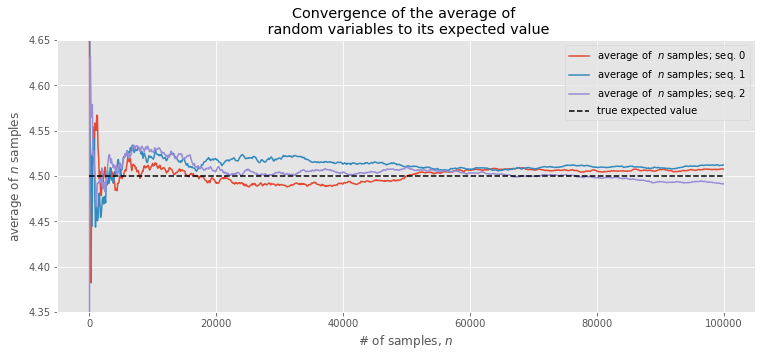

In [1]:
%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import matplotlib as mtl
mtl.style.use("ggplot")


figsize( 12.5, 5 )

sample_size = 100000
expected_value = lambda_ = 4.5
poi = np.random.poisson
N_samples = range(1,sample_size,100)

for k in range(3):

    samples = poi( lambda_, sample_size ) 
    
    partial_average = [ samples[:i].mean() for i in N_samples ]
    
    plt.plot( N_samples, partial_average, lw=1.5,label="average \
of  $n$ samples; seq. %d"%k)
    

plt.plot( N_samples, expected_value*np.ones_like( partial_average), 
    ls = "--", label = "true expected value", c = "k" )

plt.ylim( 4.35, 4.65) 
plt.title( "Convergence of the average of \n random variables to its \
expected value" )
plt.ylabel( "average of $n$ samples" )
plt.xlabel( "# of samples, $n$")
plt.legend();

In [2]:
poi(4.5, 10)

array([5, 6, 4, 4, 5, 6, 3, 5, 4, 1])

Looking at the above plot, it is clear that when the sample size is small, there is greater variation in the average (compare how *jagged and jumpy* the average is initially, then *smooths* out). All three paths *approach* the value 4.5, but just flirt with it as $N$ gets large. Mathematicians and statistician have another name for *flirting*: convergence. 

Another very relevant question we can ask is *how quickly am I converging to the expected value?* Let's plot something new. For a specific $N$, let's do the above trials thousands of times and compute how far away we are from the true expected value, on average. But wait &mdash; *compute on average*? This is simply the law of large numbers again! For example, we are interested in, for a specific $N$, the quantity:

$$D(N) = \sqrt{ \;E\left[\;\; \left( \frac{1}{N}\sum_{i=1}^NZ_i  - 4.5 \;\right)^2 \;\;\right] \;\;}$$

The above formulae is interpretable as a distance away from the true value (on average), for some $N$. (We take the square root so the dimensions of the above quantity and our random variables are the same). As the above is an expected value, it can be approximated using the law of large numbers: instead of averaging $Z_i$, we calculate the following multiple times and average them:

$$ Y_k = \left( \;\frac{1}{N}\sum_{i=1}^NZ_i  - 4.5 \; \right)^2 $$

By computing the above many, $N_y$, times (remember, it is random), and averaging them:

$$ \frac{1}{N_Y} \sum_{k=1}^{N_Y} Y_k \rightarrow E[ Y_k ] = E\;\left[\;\; \left( \frac{1}{N}\sum_{i=1}^NZ_i  - 4.5 \;\right)^2 \right]$$

Finally, taking the square root:

$$ \sqrt{\frac{1}{N_Y} \sum_{k=1}^{N_Y} Y_k} \approx D(N) $$ 

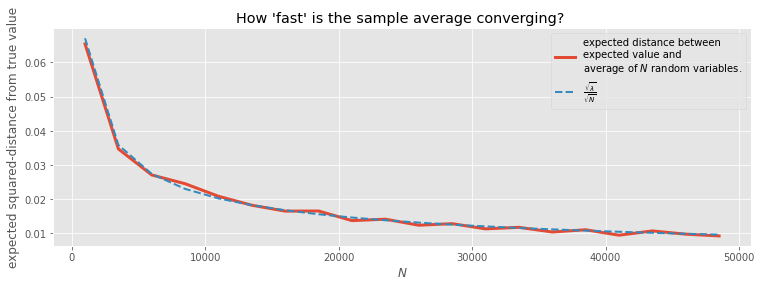

In [3]:
figsize( 12.5, 4)

N_Y = 250 #use this many to approximate D(N)
N_array = np.arange( 1000, 50000, 2500 ) #use this many samples in the approx. to the variance.
D_N_results = np.zeros( len( N_array ) )

lambda_ = 4.5 
expected_value = lambda_ #for X ~ Poi(lambda) , E[ X ] = lambda

def D_N( n ):
    """
    This function approx. D_n, the average variance of using n samples.
    """
    Z = poi( lambda_, (n, N_Y) )
    average_Z = Z.mean(axis=0)
    return np.sqrt( (  (average_Z - expected_value)**2  ).mean() )
    
    
for i,n in enumerate(N_array):
    D_N_results[i] =  D_N(n)


plt.xlabel( "$N$" )
plt.ylabel( "expected squared-distance from true value" )
plt.plot(N_array, D_N_results, lw = 3, 
            label="expected distance between\n\
expected value and \naverage of $N$ random variables.")
plt.plot( N_array, np.sqrt(expected_value)/np.sqrt(N_array), lw = 2, ls = "--", 
        label = r"$\frac{\sqrt{\lambda}}{\sqrt{N}}$" )
plt.legend()
plt.title( "How 'fast' is the sample average converging? " );

As expected, the expected distance between our sample average and the actual expected value shrinks as $N$ grows large. But also notice that the *rate* of convergence decreases, that is, we need only 10 000 additional samples to move from 0.020 to 0.015, a difference of 0.005, but *20 000* more samples to again decrease from 0.015  to 0.010, again only a 0.005 decrease.


It turns out we can measure this rate of convergence. Above I have plotted a second line, the function $\sqrt{\lambda}/\sqrt{N}$. This was not chosen arbitrarily. In most cases, given a sequence of random variable distributed like $Z$, the rate of convergence to $E[Z]$ of the Law of Large Numbers is 

$$ \frac{ \sqrt{ \; Var(Z) \; } }{\sqrt{N} }$$

This is useful to know: for a given large $N$, we know (on average) how far away we are from the estimate. On the other hand, in a Bayesian setting, this can seem like a useless result: Bayesian analysis is OK with uncertainty so what's the *statistical* point of adding extra precise digits? Though drawing samples can be so computationally cheap that having a *larger* $N$ is fine too. 

### How do we compute $Var(Z)$ though?

The variance is simply another expected value that can be approximated! Consider the following, once we have the expected value (by using the Law of Large Numbers to estimate it, denote it $\mu$), we can estimate the variance:

$$ \frac{1}{N}\sum_{i=1}^N \;(Z_i - \mu)^2 \rightarrow E[ \;( Z - \mu)^2 \;] = Var( Z )$$

### Expected values and probabilities 
There is an even less explicit relationship between expected value and estimating probabilities. Define the *indicator function*

$$\mathbb{1}_A(x) = 
\begin{cases} 1 &  x \in A \\\\
              0 &  else
\end{cases}
$$
Then, by the law of large numbers, if we have many samples $X_i$, we can estimate the probability of an event $A$, denoted $P(A)$, by:

$$ \frac{1}{N} \sum_{i=1}^N \mathbb{1}_A(X_i) \rightarrow E[\mathbb{1}_A(X)] =  P(A) $$

Again, this is fairly obvious after a moments thought: the indicator function is only 1 if the event occurs, so we are summing only the times the event occurs and dividing by the total number of trials  (consider how we usually approximate probabilities using frequencies). For example, suppose we wish to estimate the probability that a $Z \sim Exp(.5)$ is greater than 5, and we have many samples from a $Exp(.5)$ distribution. 


$$ P( Z > 5 ) =  \frac{1}{N}\sum_{i=1}^N \mathbb{1}_{z > 5 }(Z_i) $$


In [4]:
N = 10000
print( np.mean( [ np.random.exponential( 0.5 ) > 5 for i in range(N) ] ) )

0.0


### What does this all have to do with Bayesian statistics? 


*Point estimates*, to be introduced in the next chapter, in Bayesian inference are computed using expected values. In more analytical Bayesian inference, we would have been required to evaluate complicated expected values represented as multi-dimensional integrals. No longer. If we can sample from the posterior distribution directly, we simply need to evaluate averages. Much easier. If accuracy is a priority, plots like the ones above show how fast you are converging. And if further accuracy is  desired, just take more samples from the posterior. 

When is enough enough? When can you stop drawing samples from the posterior? That is the practitioners decision, and also dependent on the variance of the samples (recall from above a high variance means the average will converge slower). 

We also should understand when the Law of Large Numbers fails. As the name implies, and comparing the graphs above for small $N$, the Law is only true for large sample sizes. Without this, the asymptotic result is not reliable. Knowing in what situations the Law fails can give us *confidence in how unconfident we should be*. The next section deals with this issue.

## The Disorder of Small Numbers

The Law of Large Numbers is only valid as $N$ gets *infinitely* large: never truly attainable.  While the law is a powerful tool, it is foolhardy to apply it liberally. Our next example illustrates this.


##### Example: Aggregated geographic data


Often data comes in aggregated form. For instance, data may be grouped by state, county, or city level. Of course, the population numbers vary per geographic area. If the data is an average of some characteristic of each the geographic areas, we must be conscious of the Law of Large Numbers and how it can *fail* for areas with small populations.

We will observe this on a toy dataset. Suppose there are five thousand counties in our dataset. Furthermore,  population number in each state are uniformly distributed between 100 and 1500. The way the population numbers are generated is irrelevant to the discussion, so we do not justify this. We are interested in measuring the average height of individuals per county. Unbeknownst to us, height does **not** vary across county, and each individual, regardless of the county he or she is currently living in, has the same distribution of what their height may be:

$$ \text{height} \sim \text{Normal}(150, 15 ) $$

We aggregate the individuals at the county level, so we only have data for the *average in the county*. What might our dataset look like?

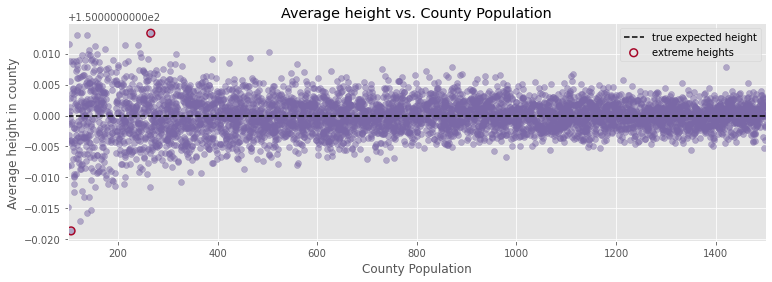

In [5]:
figsize( 12.5, 4) 
std_height = 15
mean_height = 150

n_counties = 5000
pop_generator = np.random.randint
norm = np.random.normal

#generate some artificial population numbers
population = pop_generator(100, 1500, n_counties )

average_across_county = np.zeros( n_counties )
for i in range( n_counties ):
    #generate some individuals and take the mean
    average_across_county[i] = norm(mean_height, 1./std_height,
                                        population[i] ).mean()
    
#located the counties with the apparently most extreme average heights.
i_min = np.argmin( average_across_county )
i_max = np.argmax( average_across_county )

#plot population size vs. recorded average
plt.scatter( population, average_across_county, alpha = 0.5, c="#7A68A6")
plt.scatter( [ population[i_min], population[i_max] ], 
           [average_across_county[i_min], average_across_county[i_max] ],
           s = 60, marker = "o", facecolors = "none",
           edgecolors = "#A60628", linewidths = 1.5, 
            label="extreme heights")

plt.xlim( 100, 1500 )
plt.title( "Average height vs. County Population")
plt.xlabel("County Population")
plt.ylabel("Average height in county")
plt.plot( [100, 1500], [150, 150], color = "k", label = "true expected \
height", ls="--" )
plt.legend(scatterpoints = 1);

What do we observe? *Without accounting for population sizes* we run the risk of making an enormous inference error: if we ignored population size, we would say that the county with the shortest and tallest individuals have been correctly circled. But this inference is wrong for the following reason. These two counties do *not* necessarily have the most extreme heights. The error results from the calculated average of smaller populations not being a good reflection of the true expected value of the population (which in truth should be $\mu =150$). The sample size/population size/$N$, whatever you wish to call it,  is simply too small to invoke the Law of Large Numbers effectively. 

We provide more damning evidence against this inference. Recall the population numbers were uniformly distributed over 100 to 1500. Our intuition should tell us that the counties with the most extreme population heights should also be uniformly spread over 100 to 1500, and certainly independent of the county's population. Not so. Below are the population sizes of the counties with the most extreme heights.

In [6]:
print("Population sizes of 10 'shortest' counties: ")
print(population[ np.argsort( average_across_county )[:10] ], '\n')
print("Population sizes of 10 'tallest' counties: ")
print(population[ np.argsort( -average_across_county )[:10] ])

Population sizes of 10 'shortest' counties: 
[106 124 137 147 100 141 132 112 128 155] 

Population sizes of 10 'tallest' counties: 
[266 118 137 102 241 215 155 175 141 503]


Not at all uniform over 100 to 1500. This is an absolute failure of the Law of Large Numbers. 

##### Example:  Kaggle's *U.S. Census Return Rate Challenge*

Below is data from the 2010 US census, which partitions populations beyond counties to the level of block groups (which are aggregates of city blocks or equivalents). The dataset is from a Kaggle machine learning competition some colleagues and I participated in. The objective was to predict the census letter mail-back rate of a group block, measured between 0 and 100, using census variables (median income, number of females in the block-group, number of trailer parks, average number of children etc.). Below we plot the census mail-back rate versus block group population:

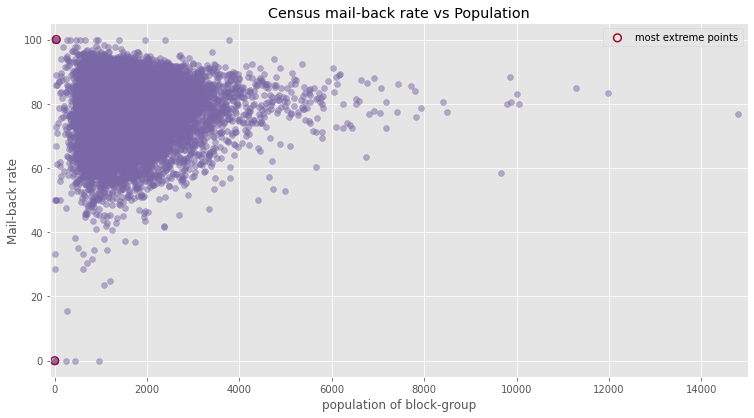

In [7]:
figsize( 12.5, 6.5 )
data = np.genfromtxt( "./data/census_data.csv", skip_header=1, 
                        delimiter= ",")
plt.scatter( data[:,1], data[:,0], alpha = 0.5, c="#7A68A6")
plt.title("Census mail-back rate vs Population")
plt.ylabel("Mail-back rate")
plt.xlabel("population of block-group")
plt.xlim(-100, 15e3 )
plt.ylim( -5, 105)

i_min = np.argmin(  data[:,0] )
i_max = np.argmax(  data[:,0] )
 
plt.scatter( [ data[i_min,1], data[i_max, 1] ], 
             [ data[i_min,0],  data[i_max,0] ],
             s = 60, marker = "o", facecolors = "none",
             edgecolors = "#A60628", linewidths = 1.5, 
             label="most extreme points")

plt.legend(scatterpoints = 1);

The above is a classic phenomenon in statistics. I say *classic* referring to the "shape" of the scatter plot above. It follows a classic triangular form, that tightens as we increase the sample size (as the Law of Large Numbers becomes more exact). 

I am perhaps overstressing the point and maybe I should have titled the book *"You don't have big data problems!"*, but here again is an example of the trouble with *small datasets*, not big ones. Simply, small datasets cannot be processed using the Law of Large Numbers. Compare with applying the Law without hassle to big datasets (ex. big data). I mentioned earlier that paradoxically big data prediction problems are solved by relatively simple algorithms. The paradox is partially resolved by understanding that the Law of Large Numbers creates solutions that are *stable*, i.e. adding or subtracting a few data points will not affect the solution much. On the other hand, adding or removing data points to a small dataset can create very different results. 

For further reading on the hidden dangers of the Law of Large Numbers, I would highly recommend the excellent manuscript [The Most Dangerous Equation](http://nsm.uh.edu/~dgraur/niv/TheMostDangerousEquation.pdf). 

##### Example: How to order Reddit submissions

You may have disagreed with the original statement that the Law of Large numbers is known to everyone, but only implicitly in our subconscious decision making. Consider ratings on online products: how often do you trust an average 5-star rating if there is only 1 reviewer? 2 reviewers? 3 reviewers? We implicitly understand that with such few reviewers that the average rating is **not** a good reflection of the true value of the product.

This has created flaws in how we sort items, and more generally, how we compare items. Many people have realized that sorting online search results by their rating, whether the objects be books, videos, or online comments, return poor results. Often the seemingly top videos or comments have perfect ratings only from a few enthusiastic fans, and truly more quality videos or comments are hidden in later pages with *falsely-substandard* ratings of around 4.8. How can we correct this?

Consider the popular site Reddit (I purposefully did not link to the website as you would never come back). The site hosts links to stories or images, called submissions, for people to comment on. Redditors can vote up or down on each submission (called upvotes and downvotes). Reddit, by default, will sort submissions to a given subreddit by Hot, that is, the submissions that have the most upvotes recently.

<img src="http://i.imgur.com/3v6bz9f.png" />


How would you determine which submissions are the best? There are a number of ways to achieve this:

1. *Popularity*: A submission is considered good if it has many upvotes. A problem with this model is that a submission with hundreds of upvotes, but thousands of downvotes. While being very *popular*, the submission is likely more controversial than best.
2. *Difference*: Using the *difference* of upvotes and downvotes. This solves the above problem, but fails when we consider the temporal nature of submission. Depending on when a submission is posted, the website may be experiencing high or low traffic. The difference method will bias the *Top* submissions to be the those made during high traffic periods, which have accumulated more upvotes than submissions that were not so graced, but are not necessarily the best.
3. *Time adjusted*:  Consider using Difference divided by the age of the submission. This creates a *rate*, something like *difference per second*, or *per minute*. An immediate counter-example is, if we use per second, a 1 second old submission with 1 upvote would be better than a 100 second old submission with 99 upvotes. One can avoid this by only considering at least t second old submission. But what is a good t value? Does this mean no submission younger than t is good? We end up comparing unstable quantities with stable quantities (young vs. old submissions).
3. *Ratio*: Rank submissions by the ratio of upvotes to total number of votes (upvotes plus downvotes). This solves the temporal issue, such that new submissions who score well can be considered Top just as likely as older submissions, provided they have many upvotes to total votes. The problem here is that a submission with a single upvote (ratio = 1.0) will beat a submission with 999 upvotes and 1 downvote (ratio = 0.999), but clearly the latter submission is *more likely* to be better.

I used the phrase *more likely* for good reason. It is possible that the former submission, with a single upvote, is in fact a better submission than the later with 999 upvotes. The hesitation to agree with this is because we have not seen the other 999 potential votes the former submission might get. Perhaps it will achieve an additional 999 upvotes and 0 downvotes and be considered better than the latter, though not likely.

What we really want is an estimate of the *true upvote ratio*. Note that the true upvote ratio is not the same as the observed upvote ratio: the true upvote ratio is hidden, and we only observe upvotes vs. downvotes (one can think of the true upvote ratio as "what is the underlying probability someone gives this submission a upvote, versus a downvote"). So the 999 upvote/1 downvote submission probably has a true upvote ratio close to 1, which we can assert with confidence thanks to the Law of Large Numbers, but on the other hand we are much less certain about the true upvote ratio of the submission with only a single upvote. Sounds like a Bayesian problem to me.



One way to determine a prior on the upvote ratio is to look at the historical distribution of upvote ratios. This can be accomplished by scraping Reddit's submissions and determining a distribution. There are a few problems with this technique though:

1. Skewed data:  The vast majority of submissions have very few votes, hence there will be many submissions with ratios near the extremes (see the "triangular plot" in the above Kaggle dataset), effectively skewing our distribution to the extremes. One could try to only use submissions with votes greater than some threshold. Again, problems are encountered. There is a tradeoff between number of submissions available to use and a higher threshold with associated ratio precision. 
2. Biased data: Reddit is composed of different subpages, called subreddits. Two examples are *r/aww*, which posts pics of cute animals, and *r/politics*. It is very likely that the user behaviour towards submissions of these two subreddits are very different: visitors are likely friendly and affectionate in the former, and would therefore upvote submissions more, compared to the latter, where submissions are likely to be controversial and disagreed upon. Therefore not all submissions are the same. 


In light of these, I think it is better to use a `Uniform` prior.


With our prior in place, we can find the posterior of the true upvote ratio. The Python script `top_showerthoughts_submissions.py` will scrape the best posts from the `showerthoughts` community on Reddit. This is a text-only community so the title of each post *is* the post. Below is the top post as well as some other sample posts:

In [8]:
#adding a number to the end of the %run call will get the ith top post.
#please notice that the praw lib to get info from reddit changed its authorize functions
#u can get some info from https://praw.readthedocs.io/en/latest/getting_started/configuration/prawini.html
%run top_showerthoughts_submissions.py 2

print("Post contents: \n")
print(top_post)

NoSectionError: No section: 'BayesianMethodsForHackers'
You provided the name of a praw.ini configuration which does not exist.

For help with creating a Reddit instance, visit
https://praw.readthedocs.io/en/latest/code_overview/reddit_instance.html

For help on configuring PRAW, visit
https://praw.readthedocs.io/en/latest/getting_started/configuration.html

Post contents: 



NameError: name 'top_post' is not defined

<Figure size 900x468 with 0 Axes>

In [ ]:
"""
contents: an array of the text from the last 100 top submissions to a subreddit
votes: a 2d numpy array of upvotes, downvotes for each submission.
"""
n_submissions = len(votes)
submissions = np.random.randint( n_submissions, size=4)
print("Some Submissions (out of %d total) \n-----------"%n_submissions)
for i in submissions:
    print('"' + contents[i] + '"')
    print("upvotes/downvotes: ",votes[i,:], "\n")

 For a given true upvote ratio $p$ and $N$ votes, the number of upvotes will look like a Binomial random variable with parameters $p$ and $N$. (This is because of the equivalence between upvote ratio and probability of upvoting versus downvoting, out of $N$ possible votes/trials). We create a function that performs Bayesian inference on $p$, for a particular submission's upvote/downvote pair.

In [9]:
import pymc as pm

def posterior_upvote_ratio( upvotes, downvotes, samples = 20000):
    """
    This function accepts the number of upvotes and downvotes a particular submission recieved, 
    and the number of posterior samples to return to the user. Assumes a uniform prior.
    """
    N = upvotes + downvotes
    with pm.Model() as model:
        upvote_ratio = pm.Uniform("upvote_ratio", 0, 1)
        observations = pm.Binomial( "obs",  N, upvote_ratio, observed=upvotes)
        
        trace = pm.sample(samples, step=pm.NUTS(),tune=int(samples/4),chains=1)
    
    
    return trace.posterior.upvote_ratio.data.T
    

Below are the resulting posterior distributions.

Sequential sampling (1 chains in 1 job)
NUTS: [upvote_ratio]


Sampling 1 chain for 5_000 tune and 20_000 draw iterations (5_000 + 20_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.8928, but should be close to 0.8. Try to increase the number of tuning steps.
Sequential sampling (1 chains in 1 job)
NUTS: [upvote_ratio]


Sampling 1 chain for 5_000 tune and 20_000 draw iterations (5_000 + 20_000 draws total) took 4 seconds.
Sequential sampling (1 chains in 1 job)
NUTS: [upvote_ratio]


Sampling 1 chain for 5_000 tune and 20_000 draw iterations (5_000 + 20_000 draws total) took 4 seconds.
Sequential sampling (1 chains in 1 job)
NUTS: [upvote_ratio]


Sampling 1 chain for 5_000 tune and 20_000 draw iterations (5_000 + 20_000 draws total) took 4 seconds.


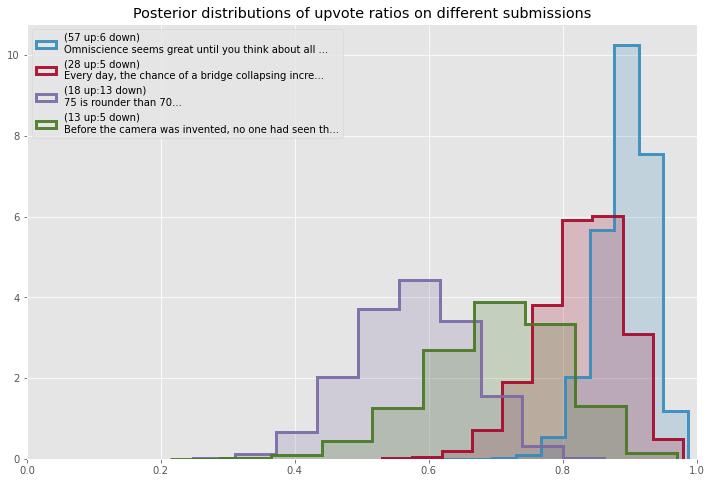

In [10]:
figsize( 12., 8)
posteriors = []
colours = ["#348ABD", "#A60628", "#7A68A6", "#467821", "#CF4457"]
for i in range(len(submissions)):
    j = submissions[i]
    posteriors.append( posterior_upvote_ratio( votes[j, 0], votes[j,1] ) )
    plt.hist( posteriors[i], bins = 10, density = True, alpha = .9, 
            histtype="step",color = colours[i%5], lw = 3,
            label = '(%d up:%d down)\n%s...'%(votes[j, 0], votes[j,1], contents[j][:50]) )
    plt.hist( posteriors[i], bins = 10, density = True, alpha = .2, 
            histtype="stepfilled",color = colours[i], lw = 3, )
    
plt.legend(loc="upper left")
plt.xlim( 0, 1)
plt.title("Posterior distributions of upvote ratios on different submissions");

Some distributions are very tight, others have very long tails (relatively speaking), expressing our uncertainty with what the true upvote ratio might be.

### Sorting!

We have been ignoring the goal of this exercise: how do we sort the submissions from *best to worst*? Of course, we cannot sort distributions, we must sort scalar numbers. There are many ways to distill a distribution down to a scalar: expressing the distribution through its expected value, or mean, is one way. Choosing the mean is a bad choice though. This is because the mean does not take into account the uncertainty of distributions.

I  suggest using the *95% least plausible value*, defined as the value such that there is only a 5% chance the true parameter is lower (think of the lower bound on the 95% credible region). Below are the posterior distributions with the 95% least-plausible value plotted:

[[0]
 [0]
 [0]
 [0]] [array([0.91212337]), array([0.78778606]), array([0.74345616]), array([0.78192709])]


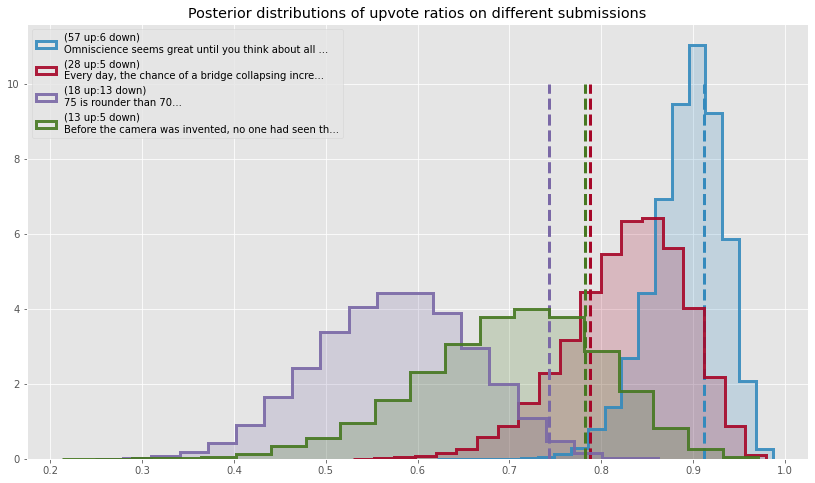

In [11]:
figsize( 14., 8)
N = posteriors[0].shape[0]
lower_limits = []

for i in range(len(submissions)):
    j = submissions[i]
    plt.hist( posteriors[i], bins = 20, density = True, alpha = .9, 
            histtype="step",color = colours[i], lw = 3,
            label = '(%d up:%d down)\n%s...'%(votes[j, 0], votes[j,1], contents[j][:50]) )
    plt.hist( posteriors[i], bins = 20, density = True, alpha = .2, 
            histtype="stepfilled",color = colours[i], lw = 3, )
    v = np.sort( posteriors[i] )[ int(0.05*N) ]
    #plt.vlines( v, 0, 15 , color = "k", alpha = 1, linewidths=3 )
    plt.vlines( v, 0, 10 , color = colours[i], linestyles = "--",  linewidths=3  )
    lower_limits.append(v)
    plt.legend(loc="upper left")

plt.legend(loc="upper left")
plt.title("Posterior distributions of upvote ratios on different submissions");
order = np.argsort( -np.array( lower_limits ) )
print(order, lower_limits)


The best submissions, according to our procedure, are the submissions that are *most-likely* to score a high percentage of upvotes. Visually those are the submissions with the 95% least plausible value close to 1.

Why is sorting based on this quantity a good idea? By ordering by the 95% least plausible value, we are being the most conservative with what we think is best.  When using the lower-bound of the 95% credible interval, we believe with high certainty that the 'true upvote ratio' is at the very least equal to this value (or greater), thereby ensuring that the best submissions are still on top. Under this ordering, we impose the following very natural properties:

1. given two submissions with the same observed upvote ratio, we will assign the submission with more votes as better (since we are more confident it has a higher ratio).
2. given two submissions with the same number of votes, we still assign the submission with more upvotes as *better*.

### But this is too slow for real-time!

I agree, computing the posterior of every submission takes a long time, and by the time you have computed it, likely the data has changed. I delay the mathematics to the appendix, but I suggest using the following formula to compute the lower bound very fast.

$$ \frac{a}{a + b} - 1.65\sqrt{ \frac{ab}{ (a+b)^2(a + b +1 ) } }$$

where 
\begin{align}
& a = 1 + u \\\\
& b = 1 + d \\\\
\end{align}

$u$ is the number of upvotes, and $d$ is the number of downvotes. The formula is a shortcut in Bayesian inference, which will be further explained in Chapter 6 when we discuss priors in more detail.


In [12]:
def intervals(u,d):
    a = 1. + u
    b = 1. + d
    mu = a/(a+b)
    std_err = 1.65*np.sqrt( (a*b)/( (a+b)**2*(a+b+1.) ) )
    return ( mu, std_err )

print("Approximate lower bounds:")
posterior_mean, std_err  = intervals(votes[:,0],votes[:,1])
lb = posterior_mean - std_err
print(lb)
print("\n")
print("Top 40 Sorted according to approximate lower bounds:")
print("\n")
order = np.argsort( -lb )
ordered_contents = []
for i in order[:40]:
    ordered_contents.append( contents[i] )
    print(votes[i,0], votes[i,1], contents[i])
    print("-------------")

Approximate lower bounds:
[0.60091591 0.535      0.65630332 0.02368603 0.34209586 0.39235808
 0.3726793  0.63447009 0.28273871 0.02368603 0.93490542 0.44960117
 0.3605993  0.50200985 0.535      0.80491887 0.69226131 0.34209586
 0.635      0.02368603 0.02368603 0.35627885 0.7609129  0.80556899
 0.42069919 0.45268299 0.55267475 0.91892384 0.35627885 0.64814153
 0.02368603 0.51514069 0.39683271 0.74107856 0.02368603 0.56085485
 0.02368603 0.40084546 0.32754218 0.02368603 0.42360758 0.83265815
 0.93950433 0.43590471 0.02368603 0.90975941 0.02368603 0.28273871
 0.02368603 0.02368603 0.61090389 0.02368603 0.46120533 0.59147534
 0.02368603 0.92871189 0.27       0.94829855 0.59321297 0.02368603
 0.4722123  0.77097389 0.82620033 0.02368603 0.82934814 0.60993921
 0.84138267 0.49569509 0.02368603 0.77681961 0.58991998 0.32754218
 0.02368603 0.68704735 0.65475736 0.43126186 0.27775794 0.4722123
 0.55184141 0.42657558 0.45093892 0.73835967 0.59123643 0.02368603
 0.47086045 0.02368603 0.02368603 0.0

We can view the ordering visually by plotting the posterior mean and bounds, and sorting by the lower bound. In the plot below, notice that the left error-bar is sorted (as we suggested this is the best way to determine an ordering), so the means, indicated by dots, do not follow any strong pattern. 

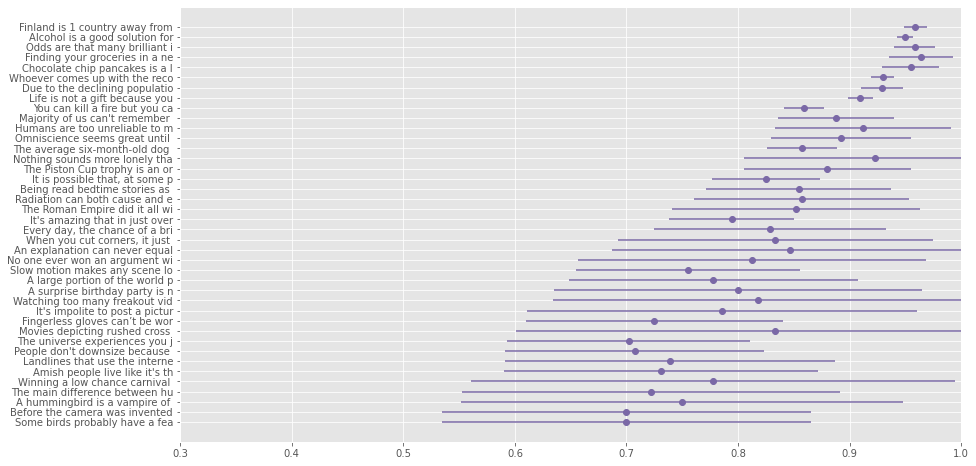

In [13]:
r_order = order[::-1][-40:]
plt.errorbar( posterior_mean[r_order], np.arange( len(r_order) ), 
               xerr=std_err[r_order], capsize=0, fmt="o",
                color = "#7A68A6")
plt.xlim( 0.3, 1)
plt.yticks( np.arange( len(r_order)-1,-1,-1 ), map( lambda x: x[:30].replace("\n",""), ordered_contents) );

In the graphic above, you can see why sorting by mean would be sub-optimal.

### Extension to Starred rating systems

The above procedure works well for upvote-downvotes schemes, but what about systems that use star ratings, e.g. 5 star rating systems. Similar problems apply with simply taking the average: an item with two perfect ratings would beat an item with thousands of perfect ratings, but a single sub-perfect rating. 


We can consider the upvote-downvote problem above as binary: 0 is a downvote, 1 if an upvote. A $N$-star rating system can be seen as a more continuous version of above, and we can set $n$ stars rewarded is equivalent to rewarding $\frac{n}{N}$. For example, in a 5-star system, a 2 star rating corresponds to 0.4. A perfect rating is a 1. We can use the same formula as before, but with $a,b$ defined differently:


$$ \frac{a}{a + b} - 1.65\sqrt{ \frac{ab}{ (a+b)^2(a + b +1 ) } }$$

where 

\begin{align}
& a = 1 + S \\\\
& b = 1 + N - S \\\\
\end{align}

where $N$ is the number of users who rated, and $S$ is the sum of all the ratings, under the equivalence scheme mentioned above. 

##### Example: Counting Github stars

What is the average number of stars a Github repository has? How would you calculate this? There are over 6 million respositories, so there is more than enough data to invoke the Law of Large numbers. Let's start pulling some data. TODO

### Conclusion

While the Law of Large Numbers is cool, it is only true so much as its name implies: with large sample sizes only. We have seen how our inference can be affected by not considering *how the data is shaped*. 

1. By (cheaply) drawing many samples from the posterior distributions, we can ensure that the Law of Large Number applies as we approximate expected values (which we will do in the next chapter).

2. Bayesian inference understands that with small sample sizes, we can observe wild randomness. Our posterior distribution will reflect this by being more spread rather than tightly concentrated. Thus, our inference should be correctable.

3. There are major implications of not considering the sample size, and trying to sort objects that are unstable leads to pathological orderings. The method provided above solves this problem.


### Appendix

##### Derivation of sorting submissions formula

Basically what we are doing is using a Beta prior (with parameters $a=1, b=1$, which is a uniform distribution), and using a Binomial likelihood with observations $u, N = u+d$. This means our posterior is a Beta distribution with parameters $a' = 1 + u, b' = 1 + (N - u) = 1+d$. We then need to find the value, $x$, such that 0.05 probability is less than $x$. This is usually done by inverting the CDF ([Cumulative Distribution Function](http://en.wikipedia.org/wiki/Cumulative_Distribution_Function)), but the CDF of the beta, for integer parameters, is known but is a large sum [3]. 

We instead use a Normal approximation. The mean of the Beta is $\mu = a'/(a'+b')$ and the variance is 

$$\sigma^2 = \frac{a'b'}{ (a' + b')^2(a'+b'+1) }$$

Hence we solve the following equation for $x$ and have an approximate lower bound. 

$$ 0.05 = \Phi\left( \frac{(x - \mu)}{\sigma}\right) $$ 

$\Phi$ being the [cumulative distribution for the normal distribution](http://en.wikipedia.org/wiki/Normal_distribution#Cumulative_distribution)






##### Exercises

1\. How would you estimate the quantity $E\left[ \cos{X} \right]$, where $X \sim \text{Exp}(4)$? What about $E\left[ \cos{X} | X \lt 1\right]$, i.e. the expected value *given* we know $X$ is less than 1? Would you need more samples than the original samples size to be equally accurate?

In [14]:
## Enter code here
import scipy.stats as stats
exp = stats.expon( scale=4 )
N = 1e5
X = exp.rvs( int(N) )
## ...

2\. The following table was located in the paper "Going for Three: Predicting the Likelihood of Field Goal Success with Logistic Regression" [2]. The table ranks football field-goal kickers by their percent of non-misses. What mistake have the researchers made?

-----

####  Kicker Careers Ranked by Make Percentage
<table><tbody><tr><th>Rank </th><th>Kicker </th><th>Make % </th><th>Number  of Kicks</th></tr><tr><td>1 </td><td>Garrett Hartley </td><td>87.7 </td><td>57</td></tr><tr><td>2</td><td> Matt Stover </td><td>86.8 </td><td>335</td></tr><tr><td>3 </td><td>Robbie Gould </td><td>86.2 </td><td>224</td></tr><tr><td>4 </td><td>Rob Bironas </td><td>86.1 </td><td>223</td></tr><tr><td>5</td><td> Shayne Graham </td><td>85.4 </td><td>254</td></tr><tr><td>… </td><td>… </td><td>…</td><td> </td></tr><tr><td>51</td><td> Dave Rayner </td><td>72.2 </td><td>90</td></tr><tr><td>52</td><td> Nick Novak </td><td>71.9 </td><td>64</td></tr><tr><td>53 </td><td>Tim Seder </td><td>71.0 </td><td>62</td></tr><tr><td>54 </td><td>Jose Cortez </td><td>70.7</td><td> 75</td></tr><tr><td>55 </td><td>Wade Richey </td><td>66.1</td><td> 56</td></tr></tbody></table>

In August 2013, [a popular post](http://bpodgursky.wordpress.com/2013/08/21/average-income-per-programming-language/) on the average income per programmer of different languages was trending. Here's the summary chart: (reproduced without permission, cause when you lie with stats, you gunna get the hammer). What do you notice about the extremes?

------

#### Average household income by programming language

<table >
 <tr><td>Language</td><td>Average Household Income ($)</td><td>Data Points</td></tr>
 <tr><td>Puppet</td><td>87,589.29</td><td>112</td></tr>
 <tr><td>Haskell</td><td>89,973.82</td><td>191</td></tr>
 <tr><td>PHP</td><td>94,031.19</td><td>978</td></tr>
 <tr><td>CoffeeScript</td><td>94,890.80</td><td>435</td></tr>
 <tr><td>VimL</td><td>94,967.11</td><td>532</td></tr>
 <tr><td>Shell</td><td>96,930.54</td><td>979</td></tr>
 <tr><td>Lua</td><td>96,930.69</td><td>101</td></tr>
 <tr><td>Erlang</td><td>97,306.55</td><td>168</td></tr>
 <tr><td>Clojure</td><td>97,500.00</td><td>269</td></tr>
 <tr><td>Python</td><td>97,578.87</td><td>2314</td></tr>
 <tr><td>JavaScript</td><td>97,598.75</td><td>3443</td></tr>
 <tr><td>Emacs Lisp</td><td>97,774.65</td><td>355</td></tr>
 <tr><td>C#</td><td>97,823.31</td><td>665</td></tr>
 <tr><td>Ruby</td><td>98,238.74</td><td>3242</td></tr>
 <tr><td>C++</td><td>99,147.93</td><td>845</td></tr>
 <tr><td>CSS</td><td>99,881.40</td><td>527</td></tr>
 <tr><td>Perl</td><td>100,295.45</td><td>990</td></tr>
 <tr><td>C</td><td>100,766.51</td><td>2120</td></tr>
 <tr><td>Go</td><td>101,158.01</td><td>231</td></tr>
 <tr><td>Scala</td><td>101,460.91</td><td>243</td></tr>
 <tr><td>ColdFusion</td><td>101,536.70</td><td>109</td></tr>
 <tr><td>Objective-C</td><td>101,801.60</td><td>562</td></tr>
 <tr><td>Groovy</td><td>102,650.86</td><td>116</td></tr>
 <tr><td>Java</td><td>103,179.39</td><td>1402</td></tr>
 <tr><td>XSLT</td><td>106,199.19</td><td>123</td></tr>
 <tr><td>ActionScript</td><td>108,119.47</td><td>113</td></tr>
</table>

### References

1. Wainer, Howard. *The Most Dangerous Equation*. American Scientist, Volume 95.
2. Clarck, Torin K., Aaron W. Johnson, and Alexander J. Stimpson. "Going for Three: Predicting the Likelihood of Field Goal Success with Logistic Regression." (2013): n. page. [Web](http://www.sloansportsconference.com/wp-content/uploads/2013/Going%20for%20Three%20Predicting%20the%20Likelihood%20of%20Field%20Goal%20Success%20with%20Logistic%20Regression.pdf). 20 Feb. 2013.
3. http://en.wikipedia.org/wiki/Beta_function#Incomplete_beta_function

In [15]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

<style>
    img{
        max-width:800px}
</style>